In [1]:
%load_ext autoreload
%autoreload 2

import os
from os import listdir
from os.path import isfile, join

import numpy as np
import matplotlib.pyplot as plt
import madmom

import sys
sys.path.append('../src')
from preprocessing import get_dataset
from models import OLSPatchRegressor
from utils import cv
import visualize

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

MUSIC = 1
SPEECH = 0

na = np.newaxis

plt.rc('text', usetex=True)
plt.rc('font', family='serif')


# --------------- FLAGS ----------
DATA = "RHYTM" # "SPECTRO"
MODEL = "CNN" # "Linear"



/home/niels/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
music_dir  = '../data/music_speech/music_wav/'
speech_dir = '../data/music_speech/speech_wav/'


def get_spectro_data():

    max_samples = -1

    X, Y = get_dataset(music_dir, speech_dir, hpool=0, wpool=0, 
                       num_samples=max_samples, shuffle=True, reload=False,
                       window=np.hanning, fps=100, num_bands=3, fmin=30, fmax=17000,
                       fft_sizes=[1024, 2048, 4096]
                      )
    print('Train Set Shape')
    print(X.shape, Y.shape)

    Y = (Y + 1) / 2 
    return X, Y
 

def get_rhythm_data():

    X, Y = load_rhythm_feature_db(music_dir, speech_dir, num_samples=-1)

    # change -1, 1 labels to 0,1
    Y = (Y + 1) / 2 

    # X is in (N,L,D) format

    X = X[:,na,:,:] # dont conv over the number of models
    return X, Y

X, Y = get_rhythm_data() if DATA == "RHYTHM" else get_spectro_data()

batch_size = 8
num_classes = 2
epochs = 20

# --------------------------------------------
num_frequencies = X.shape[1]
num_timesteps   = X.shape[2]
num_channels    = X.shape[3]
filter_time_size = 3
input_shape = num_frequencies, num_timesteps, num_channels

loaded from disk
Train Set Shape
(128, 24, 3000, 3) (128,)


In [3]:
def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

CNN = None
def get_cnn(input_shape=(input_shape), reinit=False):
    global CNN
    if CNN is None:
        
        # DEFINE MODEL
        model = Sequential()
        model.add(MaxPooling2D(pool_size=(1, 3), input_shape=input_shape))
        model.add(Conv2D(32, kernel_size=(num_frequencies, filter_time_size),
                         activation='relu'))

        model.add(Conv2D(1, kernel_size=(1, 1), activation='sigmoid'))
        model.add(Lambda(lambda x: K.mean(x, axis=[1,2])))

        model.compile(loss=keras.losses.binary_crossentropy,
                      optimizer=keras.optimizers.Adadelta(),
                      metrics=['accuracy'])
        
        CNN = model
        
        return model
    
    else:
        model = CNN
        reset_weights(model)
        return model

LINEAR = None
def get_linear(input_shape=(input_shape), reinit=False):
    global LINEAR
    if LINEAR is None:
        
        # DEFINE MODEL
        model = Sequential()
        model.add(Conv2D(1, kernel_size=(num_frequencies, filter_time_size),
                         activation='sigmoid',
                         input_shape=input_shape))

        model.add(Lambda(lambda x: K.mean(x, axis=[1,2])))

        model.compile(loss=keras.losses.binary_crossentropy,
                      optimizer=keras.optimizers.Adadelta(),
                      metrics=['accuracy'])
        
        LINEAR = model
        
        return model
    
    else:
        model = LINEAR
        reset_weights(model)
        return model

get_model = get_cnn if MODEL == "CNN" else get_linear

In [4]:
# cross validation

train_model = lambda model, X, Y: model.fit(X, Y,
                                        batch_size=batch_size,
                                        epochs=epochs,
                                        verbose=0)

# evaluate using cross-validation on training set
cvacc = cv(X, Y, get_model, train_model, nfolds=5, nrepetitions=1)
print('CV loss:', cvacc[0])
print('CV accuracy:', cvacc[1])

CV loss: 0.568319809436798
CV accuracy: 0.6960000038146973


In [7]:
split = 100
Xtrain, Ytrain, Xtest, Ytest = X[:split], Y[:split], X[split:], Y[split:]
# evaluate using train-test split
model = get_model()
train_model(model, Xtrain, Ytrain)
score = model.evaluate(Xtest, Ytest, verbose=0)
model_path = '../models/keras/'
os.makedirs(model_path, exist_ok=True)

model.save(os.path.join(model_path, '{}_on_{}-{:2.2f}.h5'.format(MODEL, DATA, score[1])))

Y_p (2, 998)
y_time (998,)


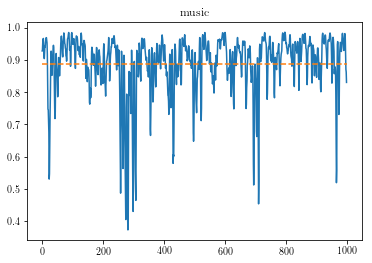

y_time (998,)


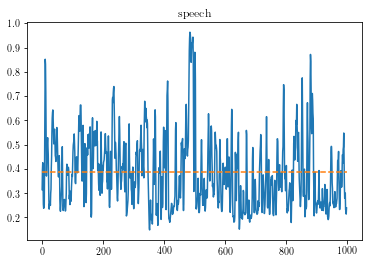

music (24, 3000, 3)
w_speech (1, 3000, 1)
audio (24, 3000, 3)
y (998,)


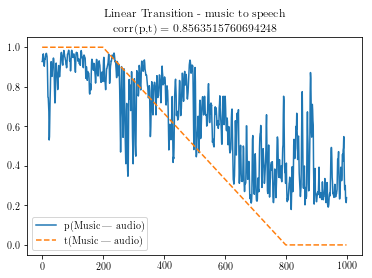

In [9]:
music = Xtest[Ytest == MUSIC][0]
speech = Xtest[Ytest == SPEECH][1]
visualize.prediction_over_time(music, speech, model)

In [ ]:
# B